# 爬取個股當日沖銷交易

爬取個股當日沖銷交易後，做成dataframe來產生圖表

In [123]:
import requests
import pandas as pd
import time
import os
from io import StringIO
import warnings
warnings.filterwarnings("ignore")

def truncate(sio):
    sio.truncate(0) # 清空第0個位置之後的資料
    sio.seek(0)  #保險一點多寫用seek從第0個位置開始添加
    return sio

save_file_path = 'day_trade'
stock_list = ['3017']
start_month = '2022-02'
end_month = '2022-03'

month_range = [str(data).replace('-','').split(' ')[0] for data in pd.date_range(start = start_month, end = end_month, freq = 'MS')]

columns = ["日期","暫停當沖註記","成交股數","買進成交金額","賣出成交金額"]
stock_df =pd.DataFrame(columns = columns)


for stock_id in stock_list:
    for m in month_range:
        url = 'https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date='+ m +'&stockNo='+stock_id
        print(' - processing:',url)
        headers = {'User-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
        res = requests.get(url, headers = headers)
        res.text
        io_csv_info = StringIO(res.text)

        while True:  # 篩選掉第一段所有股票統計
            line = io_csv_info.readline()
            if '暫停現股賣出後現款買進當沖註記' in line:    # 直接取到各股的標題列，後面的資料才是要的
                break

        while True:
            line = io_csv_info.readline()
            info_list = line.split('","')
            info_list[0] = info_list[0].strip('"')
            info_list[-1] = info_list[-1].strip('",\r\n')
        #     print(info_list)
            if '"備註:"\r\n' in line:
                break

            df = pd.DataFrame([info_list],columns = columns)
            stock_df = stock_df.append(df,ignore_index = True)
                                       
        truncate(io_csv_info) # 清除舊有的記憶體資料
        time.sleep(7)
    stock_df.to_csv(save_file_path + f'/{stock_id}.csv')
    print(f'最後日期 {stock_df.values[-1][0]} 已存檔')
stock_df

 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220201&stockNo=3017
 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220301&stockNo=3017
最後日期 111/03/10 已存檔


,日期,暫停當沖註記,成交股數,買進成交金額,賣出成交金額
0,111/02/07,,"11,951,000","1,121,440,300","1,124,922,800"
1,111/02/08,,"13,497,000","1,330,877,200","1,333,289,600"
2,111/02/09,,"13,253,000","1,372,252,000","1,375,779,500"
3,111/02/10,,"6,481,000","674,616,000","677,160,500"
4,111/02/11,,"16,841,000","1,798,868,500","1,800,633,000"
5,111/02/14,,"7,337,000","775,567,000","777,433,000"
6,111/02/15,,"7,075,000","739,462,500","741,371,000"
7,111/02/16,,"3,739,000","388,583,500","388,306,000"
8,111/02/17,,"19,165,000","2,125,766,000","2,134,456,000"
9,111/02/18,,"16,070,000","1,793,286,500","1,797,664,000"


In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob  # 類似開檔案的動作

#看一下資料內容
paths = glob.glob(f'./{save_file_path}/*.csv') 
path = paths[0]
df = pd.read_csv(path)
df = df.drop(['Unnamed: 0'], axis = 1) # 將最前面的無用index刪除
df.head(3)

,日期,暫停當沖註記,成交股數,買進成交金額,賣出成交金額
0,111/02/07,NaN,"11,951,000","1,121,440,300","1,124,922,800"
1,111/02/08,NaN,"13,497,000","1,330,877,200","1,333,289,600"
2,111/02/09,NaN,"13,253,000","1,372,252,000","1,375,779,500"


In [181]:
#因為要畫圖，所以把df內的str，改成可以被計算的int / float
type(df['成交股數'][0])
df['成交股數'] = df['成交股數'].apply(lambda x:float(x.replace(',','')) if type(x)==str else x)
df['買進成交金額'] = df['買進成交金額'].apply(lambda x:float(x.replace(',','')) if type(x)==str else x)
df['賣出成交金額'] = df['賣出成交金額'].apply(lambda x:float(x.replace(',','')) if type(x)==str else x)
df['成交股數'] = df['成交股數'].apply(lambda x:(x/1000))  # 換成張數
df['買進成交金額'] = df['買進成交金額'].apply(lambda x:(x/10000))  # 單位換成(萬)
df['賣出成交金額'] = df['賣出成交金額'].apply(lambda x:(x/10000))  # 單位換成(萬)
df['當沖損益'] = df['賣出成交金額']-df['買進成交金額']
# df['zero'] = append(0)
df

,日期,暫停當沖註記,成交股數,買進成交金額,賣出成交金額,當沖損益
0,111/02/07,NaN,11951.0,112144.03,112492.28,348.25
1,111/02/08,NaN,13497.0,133087.72,133328.96,241.24
2,111/02/09,NaN,13253.0,137225.20,137577.95,352.75
3,111/02/10,NaN,6481.0,67461.60,67716.05,254.45
4,111/02/11,NaN,16841.0,179886.85,180063.30,176.45
5,111/02/14,NaN,7337.0,77556.70,77743.30,186.60
6,111/02/15,NaN,7075.0,73946.25,74137.10,190.85
7,111/02/16,NaN,3739.0,38858.35,38830.60,-27.75
8,111/02/17,NaN,19165.0,212576.60,213445.60,869.00
9,111/02/18,NaN,16070.0,179328.65,179766.40,437.75


In [182]:
data_range_b_amount = df['買進成交金額'].tolist()
data_range_s_amount = df['賣出成交金額'].tolist()
incoming_profit = df['當沖損益'].tolist()
# data_range_b_amount

#準備x軸的數據(1,2,3,4...)
t = np.linspace(1,len(data_range_b_amount), len(data_range_b_amount) )

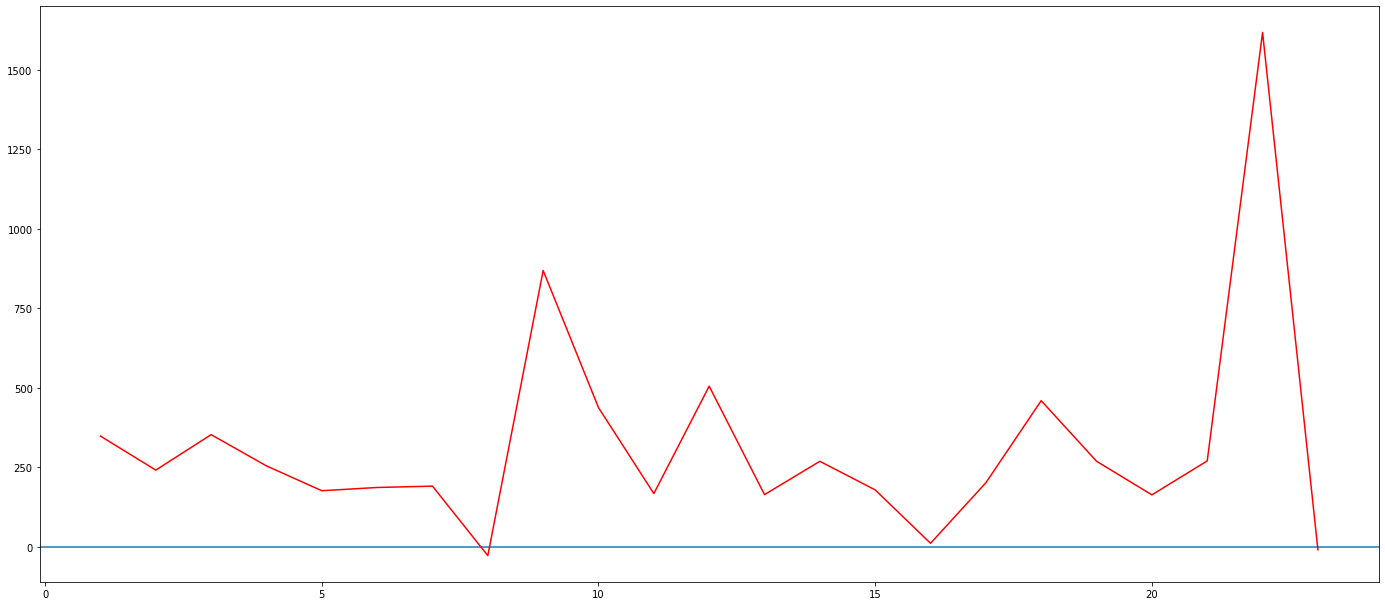

In [184]:
# 畫圖
fig = plt.figure(figsize = (24,36))  # 給一張大圖
#==========開始畫一張子圖============
ax1 = plt.subplot(311)  # 畫子圖
zeroline = 0
ax1.axhline(y=0)
ax1.plot(t,incoming_profit, color = 'red', label = 'Buy')
# ax1.plot(t,data_range_s_amount, color = 'green', label = 'Sell')
plt.show(fig)